## Filter and Trimming Messages

In [1]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
LLM = ChatGroq(model="deepseek-r1-distill-llama-70b")


## Messages as state

First, let's define some messages.

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage ,HumanMessage

messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Thomas"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Thomas

Yes, I know about whales. But what others should I learn about?


In [3]:
LLM.invoke(messages)

AIMessage(content='<think>\nOkay, the user is asking about ocean mammals beyond whales. They mentioned they know about whales but want to explore others. I should provide a comprehensive list of different species. Let me think about the main categories—like seals, sea lions, manatees, etc. I need to include each with some key facts to give them a good overview. Also, maybe suggest some interesting ones like dugongs or walruses. I should make sure to cover their habitats and unique behaviors to make it informative. Let me organize this into a list with clear headings so it\'s easy to read.\n</think>\n\nYes, there are many fascinating ocean mammals beyond whales! Here are some you might want to learn about:\n\n### 1. **Seals and Sea Lions**\n   - **Seals**: These are fin-footed, semi-aquatic marine mammals. They are closely related to sea lions and walruses but are smaller and have shorter flippers.\n   - **Sea Lions**: Larger than seals, sea lions are known for their ability to walk on 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15544\4131422813.py:1: DeprecationWarning: module 'sre_parse' is deprecated
  from sre_parse import State


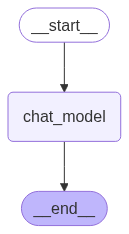

In [ ]:
from sre_parse import State
from IPython.display import display,Image
from langgraph.graph import StateGraph,START,END,MessagesState


def chat_model_node(state:MessagesState):
    return {"messages":LLM.invoke(state["messages"])}

builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [5]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Thomas

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

<think>
Okay, so the user mentioned they know about whales but are asking what other ocean mammals they should learn about. I need to provide a helpful response.

First, I should figure out the user's background. They're researching ocean mammals, so maybe they're a student or someone with a casual interest. They already know whales, so they're looking to expand their knowledge.

I should list other marine mammals besides whales. Let me think: seals, sea lions, manatees, dugongs, walruses, porpoises, and dolphins. Wait, dolphins are related to whales, but they're different enough to mention separately.

I need t

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

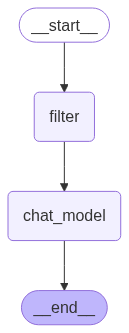

In [6]:
from langchain_core.messages import RemoveMessage

def filter_messages(state:MessagesState):
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state:MessagesState):
    return{"messages":[LLM.invoke(state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("filter",filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [7]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

<think>
Okay, so the user mentioned they know about whales but are asking what other ocean mammals they should learn about. I need to provide a comprehensive yet concise list. 

First, I should think about the different categories of marine mammals. There are cetaceans beyond whales, like dolphins and porpoises. Then pinnipeds, which include seals, sea lions, and walruses. Manatees and dugongs are sirenians. There's also the extinct Steller's sea cow. Maybe include some others like otters and the extinct Desmostylia.

I should list each with a brief description, maybe a fun fact or key characteristic to make it i

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

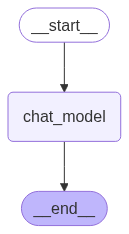

In [8]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [LLM.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [10]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

<think>
Okay, so the user mentioned they know about whales but are asking what other ocean mammals they should learn about. I need to provide a comprehensive yet concise list. 

First, I should think about the different categories of marine mammals. There are cetaceans beyond whales, like dolphins and porpoises. Then pinnipeds, which include seals, sea lions, and walruses. Manatees and dugongs are sirenians. There's also t

In [11]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

<think>
Okay, so the user mentioned they know about whales but are asking what other ocean mammals they should learn about. I need to provide a comprehensive yet concise list. 

First, I should think about the different categories of marine mammals. There are cetaceans beyond whales, like dolphins and porpoises. Then pinnipeds, which include seals, sea lions, and walruses. Manatees and dugongs are sirenians. There's also t

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

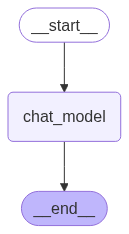

In [12]:
from langchain_core.messages import trim_messages


def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatGroq(model="deepseek-r1-distill-llama-70b"),
            allow_partial=False,
        )
    return {"messages": [LLM.invoke(messages)]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [16]:
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatGroq(model="deepseek-r1-distill-llama-70b"),
            allow_partial=False
        )

t:\LangGraph\Langchain_Acadmy_Course_on_LangGraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
t:\LangGraph\Langchain_Acadmy_Course_on_LangGraph\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Acer\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [17]:
messages_out_trim = graph.invoke({'messages': messages})

In [ ]:
messages_out_trim

{'messages': [AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
  HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
  AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
  HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
  AIMessage(content='<think>\nOkay, so the user mentioned they know about whales but are asking what other ocean mammals they should learn about. I need to provide a comprehensive yet concise list. \n\nFirst, I should think about the different categories of marine mammals. There are cetaceans beyond whales, like dolphins and porpoises. Then pinnipeds, which include seals, sea lions, and walruses. Manatees and dugongs are sirenians. There\'s also the extinct Steller\'s sea cow. Maybe include some other

: 